This workbook contains the binary classification model that I built to submit to the Kaggle Cat in the Dat II challenge: https://www.kaggle.com/c/cat-in-the-dat-ii/leaderboard. The goal of this project is to accurately classify observations with only categorical features (some low and some high-cardinality). I used XGBoost along with various encoding methods to model this data. My final submission had a ROC AUC score of .78361.

In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime
from matplotlib import pyplot
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold, train_test_split
from xgboost import plot_importance, XGBClassifier

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [0]:
train = pd.read_csv('/content/gdrive/My Drive/catdat/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/catdat/test.csv')

In [0]:
train.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')

In [0]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


Encoding notes:
- nom_0 - nom_4: one_hot
- nom_5 - nom_9: try mean
- ord_0: as-is
- ord_1, ord_2: mapping dict
- ord_3, ord_4: mean encoding
- ord_5: split chars, unicode character


In [0]:
def encoder(input_df, target, mean_encode_dicts=None):
    
    bin_cols = [col for col in input_df.columns if col[:3] == 'bin']
    one_hot_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
    mean_encode_cols = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_3', 'ord_4']
    
    if not mean_encode_dicts:
        mean_encode_dicts = {col: input_df.groupby(col)['target'].mean().to_dict() for col in mean_encode_cols}

    ord_1_dict = {'Novice': 1,
                  'Contributor': 2,
                  'Expert': 3,
                  'Master': 4,
                  'Grandmaster': 5}

    ord_2_dict = {'Freezing': 1, 
                  'Cold': 2, 
                  'Warm': 3, 
                  'Hot': 4,
                  'Boiling Hot': 5,
                  'Lava Hot': 6, }

    dummies = pd.get_dummies(input_df[one_hot_cols])
    try:
        encoded_features = pd.concat([input_df[target], dummies], axis=1)
        for col in mean_encode_cols:
            encoded_features[col + '_encoded'] = input_df[col].map(mean_encode_dicts[col])        
    except:
        encoded_features = dummies
        for col in mean_encode_cols:
            encoded_features[col + '_encoded'] = input_df[col].map(mean_encoded_mapping_dicts[col])

    encoded_features['ord_0'] = input_df['ord_0']       
    encoded_features['ord_1_encoded'] = input_df['ord_1'].map(ord_1_dict)
    encoded_features['ord_2_encoded'] = input_df['ord_2'].map(ord_2_dict)
    encoded_features['ord5_1'] = input_df['ord_5'].apply(lambda x: ord(x[0]) if pd.notnull(x) else x)
    encoded_features['ord5_2'] = input_df['ord_5'].apply(lambda x: ord(x[1]) if pd.notnull(x) else x)
    
    input_df['bin_3'] = input_df['bin_3'].apply(lambda x: 1 if x == 'T' else (0 if x == 'F' else None)).astype('bool')
    input_df['bin_4'] = input_df['bin_4'].apply(lambda x: 1 if x == 'Y' else (0 if x == 'N' else None)).astype('bool')
    
    for b in bin_cols:
        encoded_features[b] = input_df[b]
    
    encoded_features['day_sin'] =  np.sin(2*np.pi*input_df['day']/max(input_df['day']))
    encoded_features['day_cos'] =  np.cos(2*np.pi*input_df['day']/max(input_df['day']))  
    encoded_features['month_sin'] =  np.sin(2*np.pi*input_df['month']/max(input_df['month']))
    encoded_features['month_cos'] =  np.cos(2*np.pi*input_df['month']/max(input_df['month']))
    
    return encoded_features, mean_encode_dicts, mean_encode_cols

In [0]:
def mode_imputer(train_data, test_data):

  for column in test_data.columns:
      test_data[column].fillna(train_data[column].mode()[0], inplace=True)
  
  return test_data

In [0]:
def mean_imputer(train_data, test_data):
  return test_data.fillna(train_data.mean())

In [0]:
train_encoded, mean_encoded_mapping_dicts, mean_encode_cols = encoder(train, 'target')
test_encoded, _ , _ = encoder(test, 'target', mean_encoded_mapping_dicts)

In [0]:
X = train_encoded.loc[:, 'nom_0_Blue':]
y = train_encoded['target']

In [0]:
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=450,
                      objective='binary:logistic',
                      silent=False,
                      nthread=1,
                      tree_method = "gpu_hist",
                      subsample=0.6,
                      min_child_weight=5,
                      max_depth=3,
                      gamma=2,
                      colsample_bytree=0.9)

kfold = StratifiedKFold(n_splits=5, random_state=7)

# params = {'min_child_weight': [1, 5, 10],
#         'gamma': [0, 0.25, 0.5, 1.0, 1.5, 2, 5],
#         'subsample': [x/10 for x in range(5,11)],
#         'colsample_bytree': [x/10 for x in range(5,15)],
#         'max_depth': [3, 4, 5, 6, 7, 8, 9],
#         'n_estimators': [x*100 for x in range(5, 11)],
#         'learning_rate': [0.0001, 0.001, 0.01, 0.1],
#         'scale_pos_weight': [i*5 for i in range(21)]
#         }

params = {'n_estimators': [i for i in range(300,825, 25)]}

random_search = RandomizedSearchCV(model,
                                   param_distributions=params,
                                   n_iter=25,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   cv=kfold.split(X,y),
                                   verbose=20,
                                   random_state=1001,
                                   )

random_search.fit(X, y)
print(random_search.best_params_)

In [0]:
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=475,
                      objective='binary:logistic',
                      silent=False,
                      nthread=1,
                      tree_method = "gpu_hist",
                      subsample=0.6,
                      min_child_weight=5,
                      max_depth=3,
                      gamma=2,
                      colsample_bytree=0.9)


kfold = StratifiedKFold(n_splits=5)
results = cross_val_score(model, X, y,
                          cv=kfold,
                          scoring='roc_auc',
                          verbose=10)
print("AUC: %.4f%% (%.4f%%)" % (results.mean(), results.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.796, total=   4.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] .................................... , score=0.797, total=   4.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV] .................................... , score=0.797, total=   4.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.9s remaining:    0.0s


[CV] .................................... , score=0.797, total=   4.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.8s remaining:    0.0s


[CV] .................................... , score=0.796, total=   4.9s
AUC: 0.7966% (0.0005%)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.8s finished


In [0]:
len(train_encoded)

600000

In [0]:
model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=475, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.6, tree_method='gpu_hist', verbosity=1)

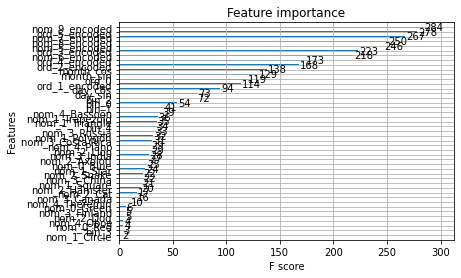

In [0]:
plot_importance(model)
pyplot.show()

In [0]:
X_test = test_encoded.loc[:, 'nom_0_Blue':]
y_pred = model.predict_proba(X_test)

In [0]:
submission = pd.concat([test['id'], pd.Series([x[1] for x in y_pred])], axis=1)
submission.columns = ['id', 'target']

In [0]:
date = datetime.now().strftime("%Y%m%d%H%M")
print(date)
submission.to_csv('cat_dat_ii_submission_' + date + '.csv', index=False)

202003311923
